In [16]:
%matplotlib inline
import gym
from gym import spaces
from matplotlib import pyplot as plt
import time
from tqdm import tqdm_notebook
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from math import floor, ceil
import random
from tensorflow.keras.layers import Dense, Concatenate, Lambda, Activation, LSTM
from tensorflow.keras import Input
from tensorflow import convert_to_tensor as convert
import pickle
COLAB = False
if not COLAB:
    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
path_base = 'models/'

In [17]:
class StockEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    
    def __init__(self, df, params, train = True):
        super(StockEnv,self).__init__()
        
        self.min_brokerage = params['min_brokerage']
        self.brokerage_rate = params['brokerage_rate']
        self.df = df
        self.state_dimensions = 6
        self.shares_normal = params['shares_normal']
        self.train = train

        self.max_steps = len(self.df.loc[:, "Open"])
        self.action_space = spaces.Box(low = -1, high = 1, shape =  (1, 1), dtype = np.float32)
        self.observation_space = spaces.Box(low = 0, high = 1, shape = (1, self.state_dimensions), dtype = np.float32)

    def reset(self, initial_balance = 10000, shares_held = None):
        self.start_balance = initial_balance 
        if self.train:
            self.current_step = np.random.randint(0, self.max_steps)
        else:
            self.current_step = 0
        self.balance = initial_balance
        self.shares_held = shares_held
        if self.shares_held is None:
            self.shares_held = 0
        self.current_price = self.get_price()
        self.net_worth = self.balance + (self.shares_held*self.current_price)
        self.initial_worth = self.net_worth
        self.max_net_worth = self.net_worth
        self.done = False
        self.frame = np.zeros((1, self.state_dimensions))
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'balance' : self.balance,
        }
        return self.observe()
        
    def get_price(self):
        return np.random.uniform(self.df.loc[self.current_step,"Low"], self.df.loc[self.current_step,"High"]) 
      
    def observe(self):
        self.frame[0, 0:4] = np.array([self.df.loc[self.current_step,'Open'],self.df.loc[self.current_step,'High'],self.df.loc[self.current_step,'Low'],self.df.loc[self.current_step,'Close']])/self.balance
        self.frame[0, 4] = self.shares_held/self.shares_normal
        self.frame[0, 5] = self.balance/self.start_balance
        self.info = {
            'current_step' : self.current_step,
            'current_price': self.current_price,
            'net_worth' : self.net_worth,
            'max_net_worth': self.max_net_worth,
            'shares_held' : self.shares_held,
            'balance' : self.balance
        }
        return self.frame, self.info
    
    def update_worth(self, reward):
        self.net_worth += reward
        self.max_net_worth = max(self.max_net_worth, self.net_worth)

    def update_balance(self, action):
        self.balance -= action*self.current_price

    def update_shares(self, action):
        self.shares_held += action

    def take_action(self, action):
        self.current_price = self.get_price()
        max_buyable = self.balance/self.current_price
        max_sellable = self.shares_held
        if action >= 0:
            action *= max_buyable
            action = floor(action)
        else:
            action *= max_sellable
            action = ceil(action)
            
        if self.shares_held == 0 and action < 0:
            reward = 0
            print ("Invallid sell action")
        else:
            self.update_balance(action)
            self.update_shares(action)
            reward = self.balance + (self.shares_held * self.current_price) - self.net_worth
            self.update_worth(reward)
        return reward
            
    def step(self, action):
        self.current_step += 1
        if self.current_step >= self.max_steps or self.done:
            self.done = True
            return np.zeros((1, self.state_dimensions)), 0, self.done, self.info

        reward = self.take_action(action)
        self.done = self.net_worth <= self.initial_worth*0.05
        if self.done:
            print('snap')
        obs, info = self.observe()
        return obs, reward, self.done, info
    
    def render(self, mode='human', close = False):
        profit = self.net_worth - self.initial_worth
        print('Step: {}'.format(self.current_step))
        print('Net Worth: {}'.format(self.net_worth))
        print('Profit: {}'.format(profit))
        
def create_stock_env(location, train=True):
    df = pd.read_csv(location).sort_values('Date')
    params = {
        'num_stocks' : 1,
        'min_brokerage' : 30.0,
        'shares_normal' : 10000,
        'brokerage_rate' : 0.001,
    }
    return StockEnv(df, params, train)

In [18]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

from collections import deque
class ReplayDeque:
    def __init__(self, capacity, element_dimensions):
        self.deque = deque()
        self.capacity = capacity
        self.dim = element_dimensions
        for _ in range(self.capacity):
            self.deque.append(np.zeros((element_dimensions, )))
            
    def add(self, obj):
        copied = np.copy(obj)
        self.deque.append(np.squeeze(copied))
        self.deque.popleft()
        
    def get_last(self, duration):
        entries = list(self.deque)[-duration:]
        shape = list(entries[0].shape)
        shape[:0] = [1, len(entries)]
        res = np.concatenate(entries).reshape(shape)
        return res
    def clear(self):
        self.__init__(self.capacity, self.dim)

In [19]:
class Agent:
    def __init__(self, params, resume=True, train=True):
        self.training = train
        self.epsilon = 1
        self.epsilon_decay = params["decay"]
        self.epsilon_min = params["min_epsilon"]
        self.discount = params["discount"]
        self.merge_frequency = params["merge_frequency"]
        self.save_frequency = params["save_frequency"]
        self.replay_length = params["replay_length"]
        self.num_actions = params["actions"]
        self.state_dimensions = params["state_dimensions"]
        self.batch_size = params["batch_size"]
        self.optimizer = params["optimizer"]
        self.experience_memory = params["memory"]
        self.buffer = ReplayMemory(self.experience_memory)
        self.past_states = ReplayDeque(self.replay_length, self.state_dimensions)
        self.count = 0
        self.game = 0
        self.input_shape = (self.replay_length, self.state_dimensions)
        self.q_network = self.build_network()
        self.target_network = self.build_network()
        if resume:
            self.load_weights()
        
    def clear_memory(self):
        self.past_states.clear()
    def merge_networks(self):
        self.target_network.set_weights(self.q_network.get_weights())
    def build_network(self):
        model = tf.keras.Sequential()
        initializer = tf.keras.initializers.GlorotUniform()
        model.add(tf.keras.layers.Dense(128, activation='relu', 
                        input_shape=self.input_shape))
        model.add(tf.keras.layers.LSTM(64, activation='relu', 
                         kernel_initializer=initializer))
        model.add(tf.keras.layers.Dense(self.num_actions, activation='linear', kernel_initializer=initializer))
        model.compile(loss='mse', optimizer=self.optimizer)
        return model
    
    def agent_start(self, observation):
        self.past_states.add(observation)
        state = (self.past_states.get_last(self.replay_length))
        q_values = np.squeeze(self.q_network(convert(state)).numpy())
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon, self.epsilon_min)
        
        if np.random.random() < self.epsilon and self.training:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(q_values)
        self.prev_state = state
        self.prev_action = action 
        return (action-10)/10
    
    def agent_step(self, reward, observation):
        self.past_states.add(observation)
        state = (self.past_states.get_last(self.replay_length))
        self.count += 1

        q_values = np.squeeze(self.q_network(convert(state)).numpy())
        relay = (self.prev_state, self.prev_action,  reward, state, 0)
        self.buffer.append(relay)
        
        if np.random.random() < self.epsilon and self.training:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(q_values)
        self.prev_state = state
        self.prev_action = action 
        if self.training:
            self.train(self.batch_size)
        
        return (action-10)/10
             
    def save_weights(self):
        self.q_network.save_weights(path_base + "main.h5")
        self.target_network.save_weights(path_base + "target.h5")
        data = (self.buffer, self.count)
        with open (path_base + 'auxiliary.pkl', 'wb') as f:
            pickle.dump(data, f)
               
    def load_weights(self):
        self.q_network.load_weights(path_base + "main.h5")
        self.target_network.load_weights(path_base + "target.h5")
        with open (path_base + 'auxiliary.pkl', 'rb') as f:
            data = pickle.load(f)
        self.buffer, self.count = data
        
    def train(self, count):
        size = min(count, self.buffer.size)
        batch = self.buffer.sample(size)
        input_tensor = np.array([state[0] for state, action, reward, future, terminated in batch])
        output_tensor = self.q_network(convert(input_tensor)).numpy()
        future_input_tensor = np.array([future[0] for state, action, reward, future, terminated in batch])
        future_out = self.target_network(convert(future_input_tensor)).numpy()
        for count, (state, action, reward, future, terminated) in enumerate(batch):
            target = output_tensor[count]
            updated = reward
            if not terminated:
                target_vals = future_out[count]
                updated += self.discount*(target_vals[np.argmax(target)])
                
            target[action] = updated
            output_tensor[count] = target 
        
        input_tensor = np.array(input_tensor)
        output_tensor = np.array(output_tensor)
        self.q_network.fit(input_tensor, output_tensor, epochs=1, verbose=0)
        if self.count%self.merge_frequency == 0:
            self.merge_networks()
            
        if self.count%self.save_frequency == 0:
            self.save_weights()
            

In [20]:
files = 'data/MSFT.csv'
env = create_stock_env(files)
tf.keras.backend.set_floatx('float32')
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
params = {"state_dimensions":6, "decay":0.995, "batch_size":32, "merge_frequency": 10000, "replay_length":10, "min_epsilon": 0.1, "save_frequency": 5000, "discount": 0.95,  "actions": 20, "optimizer": optimizer, 
          "memory": 70000}
agent = Agent(params, False)
print (agent.q_network.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10, 128)           896       
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_13 (Dense)             (None, 20)                1300      
Total params: 51,604
Trainable params: 51,604
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
def train(agent, env, epochs, profits, balances, shares, actions, steps_per_epoch):
    
    for epoch in range(0, epochs):

        cumm_profit = 0
        observation, info = env.reset(shares_held=20)
        shares[epoch, 0] = info['shares_held']
        print ("have {0}".format(shares[epoch, 0]))
        balances[epoch, 0] = info['balance']
        action = agent.agent_start(observation)
        actions[epoch, 0] = action

        for i in tqdm_notebook(range(steps_per_epoch)):
#             print (agent.past_states.deque)
            observation, reward, done, info = env.step(action)
#             print ("Observation")
#             print (observation)
#             print ("ok")
            shares[epoch, i+1] = info['shares_held']
            balances[epoch, i+1] = info['balance']
            cumm_profit += reward

            profits[epoch, i] = cumm_profit
            if done:
                print("the end")
                break
            action = agent.agent_step(reward, observation)
            actions[epoch, i+1] = action

        agent.clear_memory()
        print('Completed epoch' + str(epoch))

In [ ]:
epochs = 15
steps_per_epoch = 2000
profits = np.zeros((epochs, steps_per_epoch+1))
balances = np.zeros((epochs, steps_per_epoch+1))
shares = np.zeros((epochs, steps_per_epoch+1))
actions = np.zeros((epochs, steps_per_epoch+1))
train(agent, env, epochs, profits, balances, shares, actions, steps_per_epoch)

have 20.0


the end
Completed epoch0
have 20.0



Completed epoch1
have 20.0



Completed epoch2
have 20.0


the end
Completed epoch3
have 20.0


the end
Completed epoch4
have 20.0


the end
Completed epoch5
have 20.0



Completed epoch6
have 20.0


the end
Completed epoch7
have 20.0


the end
Completed epoch8
have 20.0


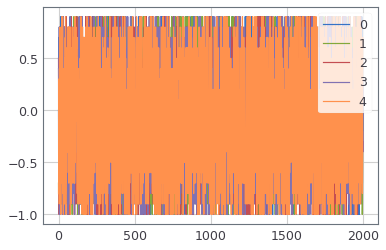

In [42]:
for _ in range(5):
    plt.plot(actions[_])

plt.legend(list(range(5)))
plt.show()

In [9]:
def test(values, env, agent):
    num = len(values)
    max_steps = env.max_steps
    profitst = np.zeros((num, max_steps+1))
    pricest = np.zeros((num, max_steps+1))
    balancest = np.zeros((num, max_steps + 1))
    sharest = np.zeros((num, max_steps+1))
    actionst = np.zeros((num, max_steps+1))
    worthst = np.zeros((num, max_steps+1))
    for count, val in enumerate(values):
        profit = 0
        profitst[count][0] = profit
        observation, info = env.reset(initial_balance = val, shares_held = 0)
        balancest[count][0] = info['balance']
        print(info['balance'])
        scale = val/info["current_price"]
        pricest[count][0] = scale*info["current_price"]
        sharest[count][0] = info['shares_held']
        worthst[count][0] = info['net_worth']
        print(info['shares_held'])
        action = agent.agent_start(observation)
        actionst[count][0] = action

        for i in tqdm_notebook(range(max_steps)):
            observation, reward, done, info = env.step(action)
            profit += reward
            profitst[count][i+1] = profit
            balancest[count][i+1] = info['balance']
            pricest[count][i+1] = scale*info["current_price"]
            sharest[count][i+1] = info['shares_held']
            worthst[count][i+1] = info['net_worth']
            if done:
                print ("ober")
                break
            action = agent.agent_step(reward, observation)
            actionst[count][i+1] = action
              
        print('Completed' + str(count) + 'values')

    print(env.net_worth)
    print(env.balance)
    print(env.shares_held)
    return profitst, balancest, sharest, actionst, worthst, pricest


In [10]:
env = create_stock_env("data/MSFT.csv", train = False)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
params = {"state_dimensions":6, "decay":0.995, "batch_size":32, "merge_frequency": 10000, "replay_length":10, "min_epsilon": 0.1, "save_frequency": 5000, "discount": 0.95,  "actions": 20, "optimizer": optimizer, 
          "memory": 70000}
agent = Agent(params, resume = True, train = False)
values = [10000]
profitst, balancest, sharest, actionst, worthst, pricest = test(values, env, agent)

10000
0


ober
Completed0values
9018.029675154796
25.114770051691032
1280


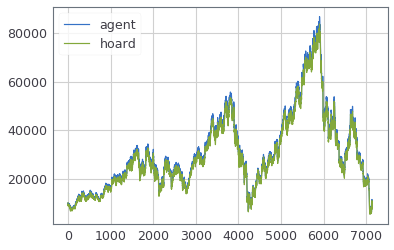

In [12]:
for i in range(1):
    plt.plot(worthst[i])
    plt.plot(pricest[i])

plt.legend(["agent", "hoard"])
plt.show()